In [1]:
import torch
import torch.nn as nn
import numpy as np
from data_process import get_data_loaders, getFeatures
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

## Flight Data

In [2]:
data = pd.read_csv('flights.csv')
data.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,0.006815,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,0.002034,0.006175,-0.116397,-9.810392,4.0,0.0,25,2019-04-07,10:13,R5
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,-0.000874,0.002696,-0.128592,-9.809440,4.0,0.0,25,2019-04-07,10:13,R5
3,1,0.5,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,0.002443,0.002024,-0.128271,-9.810159,4.0,0.0,25,2019-04-07,10:13,R5
4,1,0.6,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,-0.006425,0.008271,-0.119890,-9.812125,4.0,0.0,25,2019-04-07,10:13,R5


<Axes: title={'center': 'Flight 1'}, xlabel='position_x'>

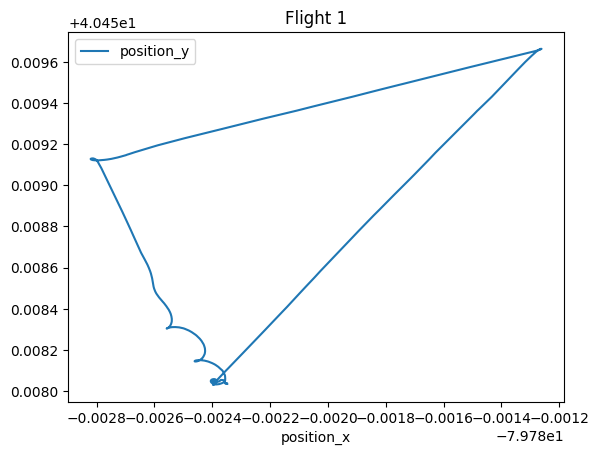

In [3]:
flight_data = data[data['flight']==1]
flight_data.plot(x='position_x', y='position_y', title='Flight 1')

We aim to predict future power in a sequence. From the engineering perspective, the future power can be related with future controls such as the acceleration. Then in this case, we consider power prediction under two scenarios: one is that we have no infomation from future, so predict the future based on current and histroic features; the other is to, beyond that, take the future trajectories as the covariates for prediciton, assuming that the mobility follows the trajectory which is usually the case when vehicle follows the navigation.

## Scenarios without covariates

### Create data loader of sequence to sequence (without Covariates)

In [4]:
# Specify the input sequence length and output sequence length
input_len, output_len = 20, 10

In [5]:
# Get all potential features of the dataloader
all_features = getFeatures(covariates=False)

# Specify the features to be used
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']

In [6]:
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=False)

['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']


### Models (without covariates)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# Model parameters
encoder_input_size = len(select_features)
decoder_input_size = encoder_input_size
hidden_size = 32  
num_layers = 1

#### LSTM-LSTM

In [9]:
from model.LSTM_LSTM import LSTM_LSTM

lstm_lstm = LSTM_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, hidden_size, num_layers=num_layers).to(device)

In [10]:
# Load saved model
lstm_lstm.load_state_dict(torch.load(f'saved_model/LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

#### TCN-LSTM

In [11]:
from model.TCN_LSTM import TCN_LSTM

tcn_lstm = TCN_LSTM(encoder_input_size, decoder_input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

In [12]:
# Load saved model
tcn_lstm.load_state_dict(torch.load(f'saved_model/TCN_LSTM_select_best_model_{input_len}-{output_len}.pt'))

<All keys matched successfully>

### Test the model

In [13]:

sum_mape = 0
sum_size = 0
for seq2seq in [lstm_lstm, tcn_lstm]:

    seq2seq.eval()
    mape_list = []
    sum_mape = 0
    sum_size = 0
    r2_score_list = np.array([])
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = seq2seq(inputs)  
            outputs = outputs.squeeze(-1)

        # print(r2_score(targets.cpu().T, outputs.cpu().T, multioutput='raw_values').shape)
    
        mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape
        sum_size += targets.shape[0]*targets.shape[1]

    print(f"{seq2seq.name} test MAPE: {sum_mape/sum_size}")

LSTM_LSTM test MAPE: 19.128232955932617
TCN_LSTM test MAPE: 16.692819595336914


In [18]:
from data_process import create_sequences

sum_mape = 0
sum_size = 0
test_flights = d_split['test']

for seq2seq in [lstm_lstm, tcn_lstm]:

    for flight_num in test_flights:

        test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.02)]
        input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                                test_data['power'].values, input_len, output_len)

        input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
        output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
        

        with torch.no_grad():
            
            outputs = seq2seq(input_seq)  # No need for target length
            # Adjust the dimensions if necessary, based on your loss function requirements
            # Example: If your outputs and targets are both [batch_size, 2, 1]
            outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
            targets = output_seq

        mape_sum = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape_sum
        sum_size += targets.shape[0]*targets.shape[1]
        # plot_output(outputs.cpu(), targets.cpu(), output_len)

    print(f"{seq2seq.name} test MAPE: {sum_mape/sum_size}")

LSTM_LSTM test MAPE: 9.169939994812012
TCN_LSTM test MAPE: 9.021327018737793


## Training Model

In [ ]:
# Data loader
input_len, output_len = 20, 10
all_features = getFeatures(covariates=False)
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 
                   'linear_acceleration_y', 'linear_acceleration_z', 'power']

data = pd.read_csv('flights.csv')
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=None, covariates=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
output_size = len(select_features)
hidden_size = 32  
num_layers = 1

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = LSTM_LSTM(input_size, output_size, input_len, output_len, hidden_size, num_layers=num_layers).to(device)

saved_model_name = f'saved_model/LSTM_LSTM_all_model_{input_len}-{output_len}.pt'

In [ ]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 20
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), saved_model_name)